In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Mount data from Drive and check files
from google.colab import drive
drive.mount('/content/drive')
import os
folder_path = '/content/drive/My Drive/citadel_hack/Datathon Materials'
# os.listdir(dataset_path)

Mounted at /content/drive


In [ ]:
# Read all data to DataFrames

years = list(range(2009, 2019))
all_data = []

for year in years:
  # read provided censes data
  census_csv_path = os.path.join(folder_path, 'Census{}.csv'.format(year))
  _df1 = pd.read_csv(census_csv_path)
  _df1 = _df1.set_index('geoid').drop(columns=_df1.columns[0])

  edu_csv_path = os.path.join(folder_path, 'extra_census_{}.csv'.format(year))
  _df2 = pd.read_csv(edu_csv_path)
  ## ["B15002_015E","Estimate!!Total!!Male!!Bachelor's degree","SEX BY EDUCATIONAL ATTAINMENT FOR THE POPULATION 25 YEARS AND OVER"],
  ## ["B15002_032E","Estimate!!Total!!Female!!Bachelor's degree","SEX BY EDUCATIONAL ATTAINMENT FOR THE POPULATION 25 YEARS AND OVER"],
  _df2 = _df2.set_index('geoid')[['B15002_015E', 'B15002_032E']]

  _df_combined = pd.concat((_df1, _df2), axis=1)
  all_data.append(_df_combined)

all_data=pd.concat(all_data, keys=years, names=['year', 'geoid'])
all_data.drop(columns=['year'],inplace=True)

# Rename column
column_names={
    'B01001_001E': 'Population',
    'B19013_001E': 'mid_Income',
    'B25077_001E': 'mid_Home_$$',
    'B03002_003E': 'Nbr_Caucasians',
    'B03002_004E': 'Nbr_Af_Americans',
    'B02001_004E': 'Nbr_Ind_Alaskans',
    'B03002_006E': 'Nbr_Asians',
    'B03002_007E': 'Nbr_Hawaiian_Pac_Islands',
    'B03002_008E': 'Nbr_others',
    'B03002_009E': 'Nbr_mult_race',
    'B03002_012E': 'Nbr_Latinos',
    'B15002_015E': 'Education_Male',
    'B15002_032E': 'Education_Female'}

all_data.rename(columns=column_names, inplace=True)
all_data['Education_total'] = all_data['Education_Female'] + all_data['Education_Male']
# all_data.head()

In [ ]:
# Data Pre-processing

### Drop negative values
all_data = all_data[all_data.select_dtypes(include=[np.number]).ge(0).all(1)]

### Normalize income/home value
US_CPI=dict(zip(range(2009, 2020), [214.537,218.056,224.939,229.594,232.957,236.736,237.017,240.007,245.12,251.107,255.657]))
for year in range(2009, 2019):
  pd.options.mode.chained_assignment = None
  all_data.loc[year, :]['mid_Income'] /= US_CPI[year] / 214.537
  all_data.loc[year, :]['mid_Home_$$'] /= US_CPI[year] / 214.537

### people count to ratio
ppl_cnt_cols = ['Nbr_Caucasians', 'Nbr_Af_Americans',	'Nbr_Ind_Alaskans',
                'Nbr_Asians',	'Nbr_Hawaiian_Pac_Islands',	'Nbr_others',
                'Nbr_mult_race', 'Nbr_Latinos', 'Education_Male', 
                'Education_Female', 'Education_total']
for col in ppl_cnt_cols:
  all_data[col] /= all_data['Population']

all_data.head()

NAME  ...  Education_total
year geoid                                                    ...                 
2009 34003001000  Census Tract 10, Bergen County, New Jersey  ...         0.233485
     34003002100  Census Tract 21, Bergen County, New Jersey  ...         0.331673
     34003002200  Census Tract 22, Bergen County, New Jersey  ...         0.144534
     34003002300  Census Tract 23, Bergen County, New Jersey  ...         0.225398
     34003003100  Census Tract 31, Bergen County, New Jersey  ...         0.204898

[5 rows x 18 columns]

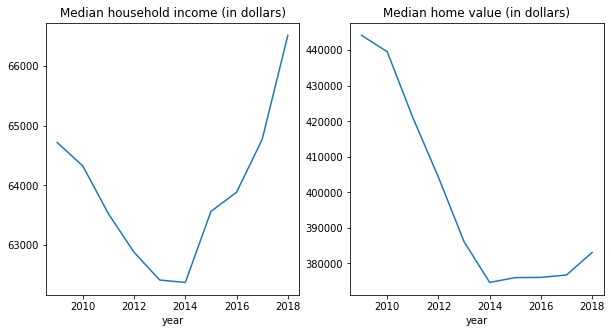

In [ ]:
# Overall people's income: 09-14: going down; 14-18: going up 
income_trend_df = all_data.loc[:, 'mid_Income'].groupby('year').quantile(0.5)
house_val_trend_df = all_data.loc[:, 'mid_Home_$$'].groupby('year').quantile(0.5)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
income_trend_df.plot(ax=axes[0], title='Median household income (in dollars)')
house_val_trend_df.plot(ax=axes[1], title='Median home value (in dollars)')
plt.show()
# Conclusions the graph below:
# 1. The increase speed of the home value after 2014 is lagged compared with the household income
# 2. The increase of the household income could be a driven souce of the gentrification
# 3. The Fincanical Crisis in 2008 has impact on household income and home value, which could suppresse the gentrification between 2009-2014

In [ ]:
# Identify eligible tracts
df09 = all_data.loc[2009]
df18 = all_data.loc[2018]
print('all tracts:', len(df09))

eligible_geoids = df09.loc[(df09['Population'] > 500)
    & (df09['mid_Home_$$'] < df09['mid_Home_$$'].quantile(0.4))
    & (df09['mid_Income'] < df09['mid_Income'].quantile(0.4))].index

## filter out tracts missing in 2018 table (since we have no way to verify wether it gentrified)
eligible_geoids = df18.index.intersection(eligible_geoids)
print('tract candidates:', len(df09.loc[eligible_geoids]))

# Identify tracts that actually gentrified
eligible09 = df09.loc[eligible_geoids]
eligible18 = df18.loc[eligible_geoids]

## Three conditions for the selection of the gentrified tracts 
### 1. education % incrase in top 1/3
### 2. mid home value increased
### 3. mid home % increase in top 1/3

eligible18['Education_pct_increase'] = eligible18['Education_total'] - eligible09['Education_total']
eligible18['mid_Home_pct_increase'] = (eligible18['mid_Home_$$'] - eligible09['mid_Home_$$']) / eligible09['mid_Home_$$']
eligible18['gentrified'] = (eligible18['Education_pct_increase'] > eligible18['Education_pct_increase'].quantile(0.66)) & (eligible18['mid_Home_pct_increase'] > 0) & (eligible18['mid_Home_pct_increase'] > eligible18['mid_Home_pct_increase'].quantile(0.66))
print('gentrified:', sum(eligible18['gentrified']))

# Calculate gentrified_ratio
gentrified_ratio = sum(eligible18['gentrified'] / len(df09.loc[eligible_geoids]))
print('gentrified ratio = gentrified tracts / eligible tracts = ', '{:.2%}'.format(gentrified_ratio))

all tracts: 4393
tract candidates: 691
gentrified: 74
gentrified ratio = gentrified tracts / eligible tracts =  10.71%


If we follow the strict criteria for the selction of gentrified tracts, we'll only get 74 tracts from the candidates which is quite small and unbalanced datasets.

We decided to slightly make the criteria less strict and get a slight larger amount of gentrified tracts (See EDA1).

In [ ]:
# Plot the home price changes in gentrified tracts and eligible but not-gentrified tracts

all_eligible_idx = eligible_geoids
## only keep eligible tract if its record appears in all years
for y in range(2010, 2018):
  all_eligible_idx = all_data.loc[y].index.intersection(all_eligible_idx)

# 656 eligible, 67 gentrified, 589 not
gentrified_idx = eligible18[eligible18['gentrified']].index.intersection(all_eligible_idx)
eligible_but_not_gentrified_idx = eligible18[~eligible18['gentrified']].index.intersection(all_eligible_idx)

In [ ]:
# Three types of the tracts: 
# 'not eligible' - not eligible tracts
# 'eligible'- eligible tracts but not gentrified
# 'gentrified' - gentrified tracts
all_data['gentrify_status'] = 'not_eligible'
for _year in range(2009, 2019):
  _df = all_data.loc[_year].loc[gentrified_idx]
  _df['gentrify_status'] = 'gentrified'
  all_data.loc[_year].loc[gentrified_idx] = _df
  
  _df = all_data.loc[_year].loc[eligible_but_not_gentrified_idx]
  _df['gentrify_status'] = 'eligible'
  all_data.loc[_year].loc[eligible_but_not_gentrified_idx] = _df

In [ ]:
# Examples: how median education rate changes in 10 years for gentrified/not tracts
# print(all_data[all_data['gentrify_status'] == 'gentrified'].loc[:, 'Education_total'].groupby('year').median())
# print(all_data[all_data['gentrify_status'] == 'eligible'].loc[:, 'Education_total'].groupby('year').median())
# print(all_data[all_data['gentrify_status'] == 'not_eligible'].loc[:, 'Education_total'].groupby('year').median())

edu_gen = all_data[all_data['gentrify_status'] == 'gentrified'].loc[:, 'Education_total'].groupby('year').median()
edu_eligible = all_data[all_data['gentrify_status'] == 'eligible'].loc[:, 'Education_total'].groupby('year').median()
edu_noteligible = all_data[all_data['gentrify_status'] == 'not_eligible'].loc[:, 'Education_total'].groupby('year').median()

mid_Income_gen = all_data[all_data['gentrify_status'] == 'gentrified'].loc[:, 'mid_Income'].groupby('year').median()
mid_Income_eligible = all_data[all_data['gentrify_status'] == 'eligible'].loc[:, 'mid_Income'].groupby('year').median()
mid_Income_noteligible = all_data[all_data['gentrify_status'] == 'not_eligible'].loc[:, 'mid_Income'].groupby('year').median()

mid_Home_gen = all_data[all_data['gentrify_status'] == 'gentrified'].loc[:, 'mid_Home_$$'].groupby('year').median()
mid_Home_eligible = all_data[all_data['gentrify_status'] == 'eligible'].loc[:, 'mid_Home_$$'].groupby('year').median()
mid_Home_noteligible = all_data[all_data['gentrify_status'] == 'not_eligible'].loc[:, 'mid_Home_$$'].groupby('year').median()

Text(0.5, 1.0, 'Education ratio')

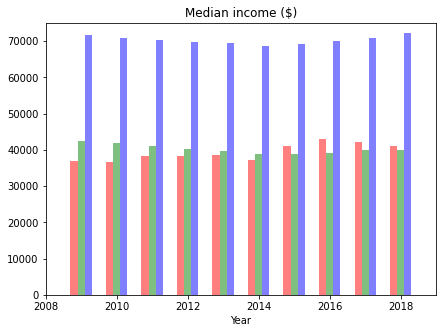

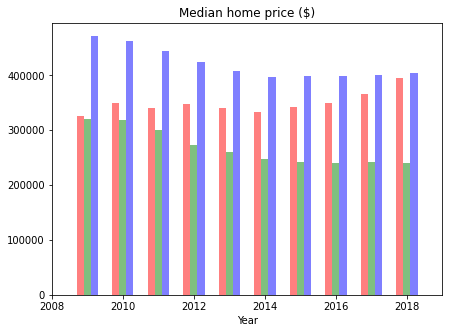

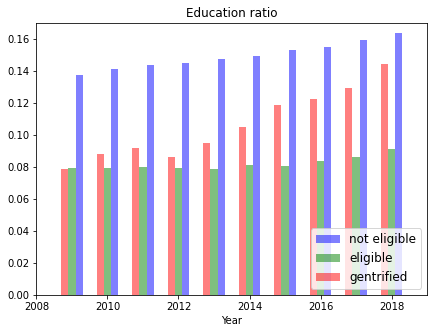

In [ ]:
# Plot how median education rate changes in 10 years
width = 0.2  # the width of the bars
# -------------------------------
fig, ax = plt.subplots(figsize=(7, 5))
ax.bar(mid_Income_noteligible.index + width, mid_Income_noteligible, width, color='b', label='not eligible',alpha=0.5)
ax.bar(mid_Income_eligible.index, mid_Income_eligible, width, color='g', label='eligible', alpha=0.5)
ax.bar(mid_Income_gen.index - width, mid_Income_gen, width, color='r',label='gentrified', alpha=0.5)
xlim=(2008, 2019)
ylim=(0,75000)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.legend(fontsize='large',loc='lower right',)
ax.set_xlabel("Year")
ax.set_title("Median income ($)")
ax.get_legend().remove()
# -------------------------------
fig, ax = plt.subplots(figsize=(7, 5))
ax.bar(mid_Home_noteligible.index + width, mid_Home_noteligible, width, color='b', label='not eligible',alpha=0.5)
ax.bar(mid_Home_eligible.index, mid_Home_eligible, width, color='g', label='eligible', alpha=0.5)
ax.bar(mid_Home_gen.index - width, mid_Home_gen, width, color='r',label='gentrified', alpha=0.5)
xlim=(2008, 2019)
# ylim=(0,75000)
ax.set_xlim(xlim)
# ax.set_ylim(ylim)

ax.legend(fontsize='large',loc='lower right',)
ax.set_xlabel("Year")
ax.set_title("Median home price ($)")
ax.get_legend().remove()
# -------------------------------
fig, ax = plt.subplots(figsize=(7, 5))
ax.bar(edu_noteligible.index + width, edu_noteligible, width, color='b', label='not eligible',alpha=0.5)
ax.bar(edu_eligible.index, edu_eligible, width, color='g', label='eligible', alpha=0.5)
ax.bar(edu_gen.index - width, edu_gen, width, color='r',label='gentrified', alpha=0.5)
xlim=(2008, 2019)
ylim=(0,0.17)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.legend(fontsize='large',loc='lower right',)
ax.set_xlabel("Year")
# ax.set_ylabel("Education ratio")
ax.set_title("Education ratio")
# -------------------------------

From the results above, we can see:
1.   Not eligible tracts are actually the developed tracts with high education
2.   Gentrified tracts have doubled the education ratio during the past decade
3.   Eligble but not gentrified tracts do not have an obvious increase of the education ratio



In [ ]:
# eligible18[eligible18['gentrified']].describe()

In [ ]:
# eligible18[~eligible18['gentrified']].describe()

In [ ]:
# all_data.loc[2018].loc[34013006200]

In [ ]:
from sklearn.linear_model import LinearRegression
races = ['Nbr_Caucasians',	'Nbr_Af_Americans',	'Nbr_Ind_Alaskans',	'Nbr_Asians',	'Nbr_Hawaiian_Pac_Islands',	'Nbr_others',	'Nbr_mult_race', 'Nbr_Latinos']

X = all_data.loc[2018][races]
y = all_data.loc[2018]['mid_Income']


lr = LinearRegression()
lr.fit(X, y)
sorted(list(zip(races, lr.coef_ + lr.intercept_)), key=lambda x: x[1], reverse=True)

[('Nbr_mult_race', 179904.03615632938),
 ('Nbr_Caucasians', 103137.98551798575),
 ('Nbr_others', 99681.61187804658),
 ('Nbr_Asians', 66335.8130004973),
 ('Nbr_Af_Americans', 47946.42232333675),
 ('Nbr_Latinos', 17128.198513910887),
 ('Nbr_Ind_Alaskans', -49656.013816940904),
 ('Nbr_Hawaiian_Pac_Islands', -160696.0740216982)]

In [ ]:
# ## line graph by years

# df = all_data[all_data['gentrify_status'] == 'eligible'].copy()
# df['Education_#'] = df['Education_total'] * df['Population']
# # df = df[df['Education_#'] < 600]
# _ = plt.plot(range(2009, 2019), df['Nbr_Latinos'].unstack(level='year').sample(frac=0.01).T)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbd9bb00940>,
      dtype=object)

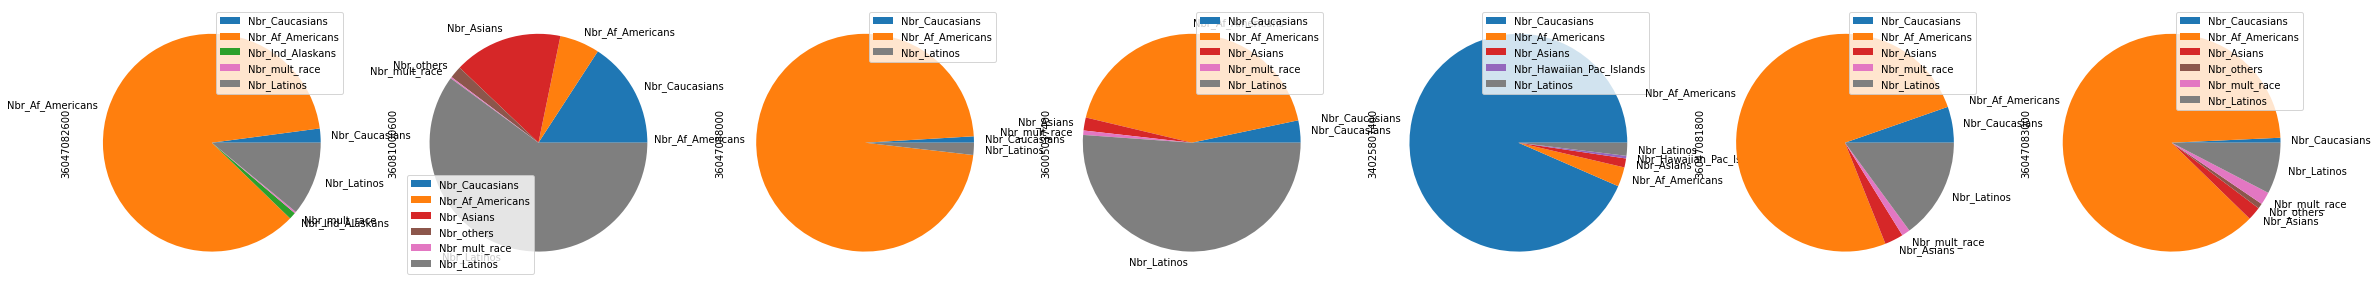

In [ ]:
### Pie graph 1/2--> to get the diversity changes in some tracts from 2009 to 2018
# The below pie graphs are about the population composition in each tract in 2009
idxs = all_data[all_data['gentrify_status'] == 'gentrified'].loc[2009].sample(frac=0.1).index
df_pie_09 = all_data.loc[2009].loc[idxs][races]
df_pie_09.T.plot.pie(subplots=True, figsize=(40, 6))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fbdab9287b8>,
      dtype=object)

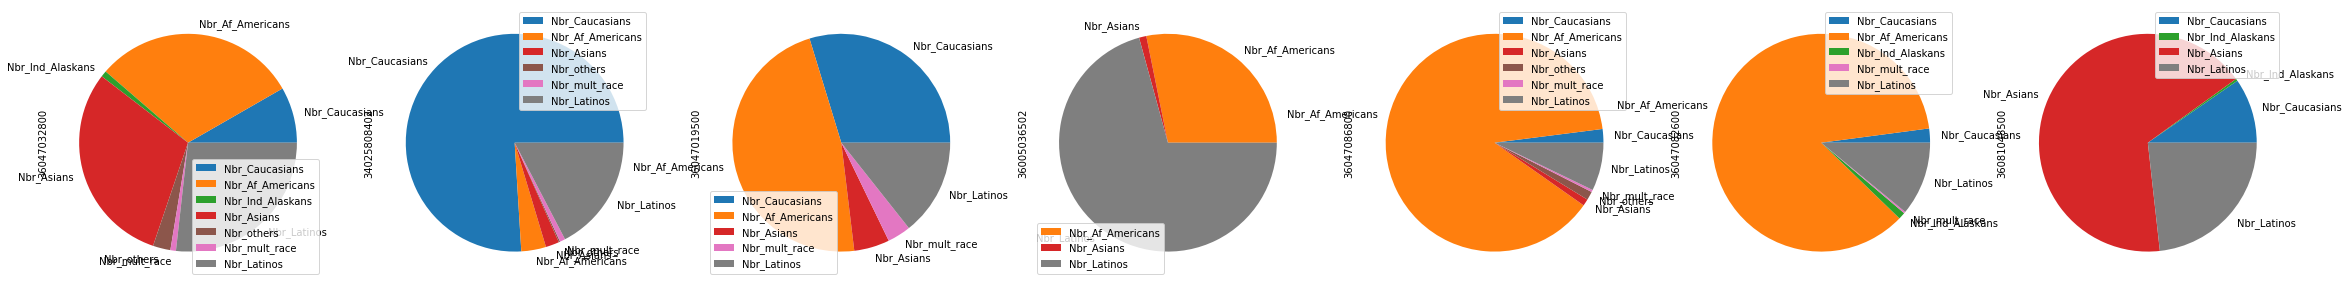

In [ ]:
### Pie graph 2/2--> to get the diversity changes in some tracts from 2009 to 2018
# The below pie graphs are about the population composition in each tract in 2018
idxs = all_data[all_data['gentrify_status'] == 'gentrified'].loc[2018].sample(frac=0.1).index
df_pie_09 = all_data.loc[2009].loc[idxs][races]
df_pie_09.T.plot.pie(subplots=True, figsize=(40, 6))

we roughly can see from above pie graphs that **the diversity of ethnic increased in gentrified tracts**. Then, we got an idea of using **entropy** to describe the change of ethnic groups.

In [ ]:
"""
Idea： most tract has a majority race group. Whether the diff(majority_race_#) is correlated with gentrification?
"""
races = ['Nbr_Caucasians',	'Nbr_Af_Americans',	'Nbr_Ind_Alaskans',	'Nbr_Asians',	'Nbr_Hawaiian_Pac_Islands',	'Nbr_others',	'Nbr_mult_race', 'Nbr_Latinos']
from scipy.stats import entropy
all_data['gentrify_01'] = 1 * (all_data['gentrify_status'] == 'gentrified')
all_data['race_entroyp'] = entropy(all_data[races], axis=1)
all_data['majority_race'] = np.max(all_data[races], axis=1)

df09_all_eligible = all_data[all_data['gentrify_status'] != 'not_eligible'].loc[2009].copy()
df18_all_eligible = all_data[all_data['gentrify_status'] != 'not_eligible'].loc[2018].copy()

# race entropy is positively correlated with gentrification result: 0.0858455945306569
(df18_all_eligible['race_entroyp'] - df09_all_eligible['race_entroyp']).corr(all_data['gentrify_01'])

0.0858455945306569

In [ ]:
#######################################################
# Try features from Marouen for Machnine Learning
#######################################################
df = pd.read_csv('/content/drive/My Drive/CitadelDatathon2020/data/features.csv')
df['gentrified'].describe()

count    1030.000000
mean        0.117476
std         0.322143
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: gentrified, dtype: float64

In [ ]:
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = pd.read_csv('/content/drive/My Drive/CitadelDatathon2020/data/features.csv')

### One-hot encode geoid
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False)
# X['geoid'] //= 1e6
# X['geoid'] = X['geoid'].astype(int)
X = pd.DataFrame(enc.fit_transform((X[['geoid']]//1e6)).astype(int)).merge(X, left_index=True, right_index=True)

### Add intial entropy
X.insert(len(X.columns)-1, 'Nbr_others', 1 - np.sum(X[['Nbr_Caucasians', 'Nbr_Af_Americans', 'Nbr_Asians', 'Nbr_Latinos']], axis=1))
X.insert(0, 'race_entroyp', entropy(X[['Nbr_Caucasians', 'Nbr_Af_Americans', 'Nbr_Asians', 'Nbr_Latinos', 'Nbr_others']] + 0.01, axis=1))

### Add trned/init_ratio
for col in ['Nbr_Caucasians', 'Nbr_Af_Americans', 'Nbr_Asians', 'Nbr_Latinos', 'Nbr_others']:
  _col_name = col + ' Trend_2'
  X.insert(len(X.columns)-1, _col_name, (X[col + ' Trend'] / (X[col] + 0.01)))
  # X[_col_name] = X[_col_name] * (1 * (X[_col_name] > 0))

### Try to add entropy diff between 2013/2009
X = pd.DataFrame(all_data.loc[2013]['race_entroyp'] - all_data.loc[2009]['race_entroyp']).merge(X, left_on=['geoid'], right_on=['geoid'], suffixes=['_diff', ''], how='right')
X['race_entroyp_diff'].fillna(0, inplace=True)

### Drop geoid
X = X.drop(axis=1, columns=['geoid'])

X_train, X_val, y_train, y_val = train_test_split(X.iloc[:,:-1], X.iloc[:,-1], test_size=0.3, random_state=42)

### only normalize part of columns
features_to_scale = X_train.columns
scaler = StandardScaler()
scaler.fit(X_train[features_to_scale])
X_train[features_to_scale]=scaler.transform(X_train[features_to_scale])
X_val[features_to_scale]=scaler.transform(X_val[features_to_scale])

X_train = pd.DataFrame(X_train, columns=X.columns[:-1])
X_val = pd.DataFrame(X_val, columns=X.columns[:-1])

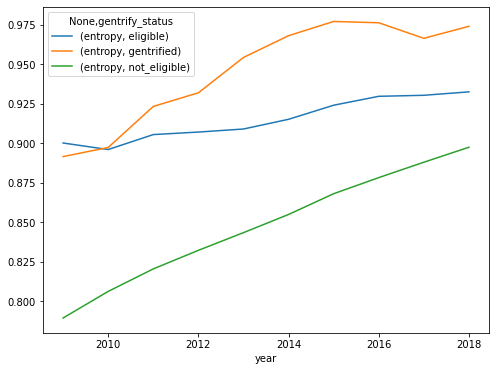

In [ ]:
# plot how entropy changes year by year for different group of tracts
races = ['Nbr_Caucasians',	'Nbr_Af_Americans',	'Nbr_Ind_Alaskans',	'Nbr_Asians',	'Nbr_Hawaiian_Pac_Islands',	'Nbr_others',	'Nbr_mult_race', 'Nbr_Latinos']
from scipy.stats import entropy
all_data['entropy'] = entropy(all_data[races], axis=1)
all_data[['entropy', 'gentrify_status']].groupby(['year', 'gentrify_status']).mean().unstack('gentrify_status').plot(figsize=(8, 6))

In [ ]:
Cs=[0.1,0.5,0.8,1,2,5,10,100,1000]
Cs=np.linspace(50,100,1000)
clf = LogisticRegressionCV(random_state=42,Cs=Cs,class_weight='balanced').fit(X_train,y_train)
clf.C_
print(classification_report(y_train,clf.predict(X_train)))
print(classification_report(y_val,clf.predict(X_val)))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       0.97      0.75      0.85       638
           1       0.30      0.83      0.44        83

    accuracy                           0.76       721
   macro avg       0.64      0.79      0.65       721
weighted avg       0.89      0.76      0.80       721

              precision    recall  f1-score   support

           0       0.96      0.70      0.81       271
           1       0.27      0.79      0.41        38

    accuracy                           0.72       309
   macro avg       0.62      0.75      0.61       309
weighted avg       0.88      0.72      0.76       309



In [ ]:
sorted(zip(X.columns[:-1], clf.coef_[0]), key=lambda x:x[1])

[(11, -1.1495807256066095),
 (17, -1.055273447425012),
 (4, -1.038951251363441),
 (0, -0.9521642445659476),
 ('mid_Income', -0.8897420848676781),
 (21, -0.8624825906013145),
 (15, -0.8474659955111242),
 (19, -0.7240559550687521),
 (23, -0.5521482774239909),
 (10, -0.4965596594631655),
 (9, -0.3875015463122376),
 ('Nbr_others Trend_2', -0.36593002445823253),
 (6, -0.35818431453503535),
 ('Nbr_Caucasians Trend', -0.30341636455438303),
 ('Nbr_Asians Trend_2', -0.2885383656110781),
 ('Nbr_Af_Americans Trend_2', -0.2788071631938215),
 (3, -0.2619475538606442),
 ('Nbr_Caucasians', -0.1323934833014084),
 ('race_entroyp', -0.11688861926550428),
 ('Nbr_Af_Americans', -0.11262826668345244),
 (8, -0.024953393724270627),
 ('Nbr_Latinos Trend_2', -0.018675291720302477),
 (2, 0.03987040360527032),
 ('Nbr_Latinos Trend', 0.061981918416997385),
 ('Nbr_Asians', 0.06880872205520455),
 ('Nbr_Caucasians Trend_2', 0.1265952963322263),
 ('mid_Income Trend', 0.14038419430428326),
 ('Nbr_Af_Americans Trend', 

In [ ]:
# clf = LogisticRegression(random_state=42,C=74,class_weight='balanced').fit(X_train,y_train)
# print(classification_report(y_train,clf.predict(X_train)))
# print(classification_report(y_val,clf.predict(X_val)))

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=10, class_weight='balanced')
clf = clf.fit(X_train, y_train)
print(classification_report(y_train, clf.predict(X_train)))
print(classification_report(y_val, clf.predict(X_val)))
# tree.plot_tree(clf, fontsize=12, feature_names=X_train.columns)

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       638
           1       0.78      1.00      0.87        83

    accuracy                           0.97       721
   macro avg       0.89      0.98      0.93       721
weighted avg       0.97      0.97      0.97       721

              precision    recall  f1-score   support

           0       0.91      0.85      0.88       271
           1       0.29      0.42      0.34        38

    accuracy                           0.80       309
   macro avg       0.60      0.64      0.61       309
weighted avg       0.84      0.80      0.82       309



In [ ]:
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

X_svm_train = X_train[:-100]
X_svm_validation = X_train[-100:]
y_svm_train = y_train[:-100]
y_svm_validation = y_train[-100:]

for c in range(1, 201, 10):
  clf = svm.SVC(random_state=42, kernel='poly', C=c, class_weight='balanced')
  clf.fit(X_svm_train, y_svm_train)
  print(c, f1_score(y_svm_validation, clf.predict(X_svm_validation)))

1 0.3529411764705882
11 0.3448275862068966
21 0.23076923076923078
31 0.24000000000000005
41 0.25
51 0.25
61 0.25
71 0.25
81 0.25
91 0.25
101 0.25
111 0.25
121 0.25
131 0.2608695652173913
141 0.2608695652173913
151 0.2608695652173913
161 0.2608695652173913
171 0.2608695652173913
181 0.2608695652173913
191 0.2608695652173913


In [ ]:
clf = svm.SVC(random_state=42, kernel='poly', C=11, class_weight='balanced')
clf.fit(X_train, y_train)
print(classification_report(y_svm_train, clf.predict(X_svm_train)))
print(classification_report(y_svm_validation, clf.predict(X_svm_validation)))
print(classification_report(y_val, clf.predict(X_val)))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96       547
           1       0.65      0.99      0.78        74

    accuracy                           0.93       621
   macro avg       0.82      0.96      0.87       621
weighted avg       0.96      0.93      0.94       621

              precision    recall  f1-score   support

           0       1.00      0.89      0.94        91
           1       0.47      1.00      0.64         9

    accuracy                           0.90       100
   macro avg       0.74      0.95      0.79       100
weighted avg       0.95      0.90      0.91       100

              precision    recall  f1-score   support

           0       0.90      0.85      0.88       271
           1       0.23      0.32      0.27        38

    accuracy                           0.79       309
   macro avg       0.56      0.58      0.57       309
weighted avg       0.82      0.79      0.80       309



              precision    recall  f1-score   support

           0       0.99      0.85      0.92       638
           1       0.45      0.96      0.62        83

    accuracy                           0.86       721
   macro avg       0.72      0.91      0.77       721
weighted avg       0.93      0.86      0.88       721

              precision    recall  f1-score   support

           0       0.96      0.80      0.87       271
           1       0.34      0.74      0.46        38

    accuracy                           0.79       309
   macro avg       0.65      0.77      0.67       309
weighted avg       0.88      0.79      0.82       309



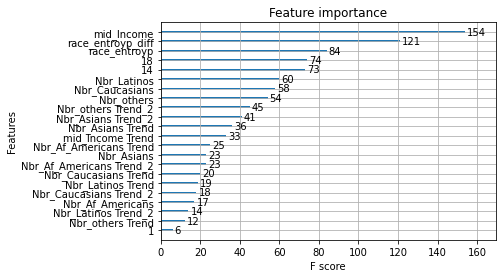

In [ ]:
from xgboost import XGBClassifier
from xgboost import plot_importance

counts=y_train.value_counts()
s_weight = counts[0]/counts[1]
model = XGBClassifier(learning_rate=0.01,
                      n_estimators=50,           # No of tree xgboost
                      max_depth=10,              # Depth of tree
                      min_child_weight = 9,      # Min weights 
                      gamma=0.,                  # Weights before peanlty
                      subsample=1,               # all samples used to build tree
                      colsample_btree=1,         # all features used to build tree
                      scale_pos_weight=s_weight,        # solve the unbalanced problem
                      random_state=42,           # random number
                      slient = 0,
                      seed=42,
                      n_jobs = -1
                      )
model.fit(X_train, y_train)
print(classification_report(y_train, model.predict(X_train)))
print(classification_report(y_val, model.predict(X_val)))
plot_importance(model)

              precision    recall  f1-score   support

           0       1.00      0.89      0.94       638
           1       0.53      0.98      0.69        83

    accuracy                           0.90       721
   macro avg       0.76      0.93      0.81       721
weighted avg       0.94      0.90      0.91       721

              precision    recall  f1-score   support

           0       0.92      0.83      0.87       271
           1       0.28      0.47      0.35        38

    accuracy                           0.79       309
   macro avg       0.60      0.65      0.61       309
weighted avg       0.84      0.79      0.81       309



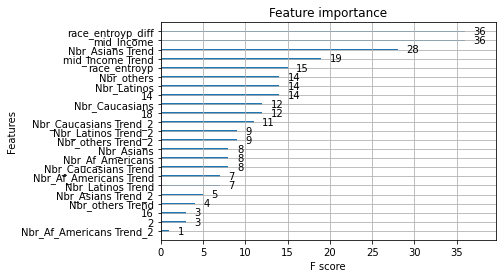

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
counts=y_train.value_counts()
clf = XGBClassifier(seed=42,scale_pos_weight=counts[0]/counts[1],n_estimators=50,max_depth=3,njobs=-1,min_child_weight=9)
clf.fit(X_train, y_train)
print(classification_report(y_train, clf.predict(X_train)))
print(classification_report(y_val, clf.predict(X_val)))
plot_importance(clf)